# Sistema de recomendacion de Anime

### Integrantes : 
-  Verónica Martinez
- Alejandra Aravena
- Hugo Zuñiga
- Cesar Flores

In [1]:
#importar librerias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from numpy import random

In [2]:
# Cargamos la base de datos y realizamos algunas exploraciones

In [3]:
df_anime = pd.read_csv("Anime.csv", sep=';', decimal=',')
df_ratings = pd.read_csv("rating.csv")

In [4]:
df_anime.shape
#veamos numeros de filas y columnas 

(12294, 7)

In [5]:
df_ratings.shape
#veamos numeros de filas y columnas 

(7813737, 3)

In [6]:
df_ratings.info()
# informacion de las variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


In [7]:
df_ratings.head()

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

In [8]:
#Segun info otorgada el -1 corresponde a anime que no tiene valoracion por parte del usuario

In [9]:
df_anime.info()
#Info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
anime_id    12294 non-null int64
name        12294 non-null object
genre       12247 non-null object
type        12269 non-null object
episodes    12294 non-null object
rating      12064 non-null float64
members     12294 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 672.4+ KB


In [10]:
n_users = df_ratings.user_id.unique().shape[0]
n_users
# cantidad de usuarios

73515

In [11]:
n__users = df_ratings.user_id.unique().shape[0] #cantidad usuarios
n__items = df_ratings.anime_id.unique().shape[0]# cantidad anime
print (str(n__users) + ' users')
print (str(n__items) + ' items')

73515 users
11200 items


In [12]:
#Empezamos con la modelacion
##buscamos valores nulos en las columnas genero, tipo y ratings

In [13]:
df_anime[df_anime['genre'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                  name genre   type episodes  rating  members
9105     34292        Kamigami no Ki   NaN     TV  Unknown    4.33       76
7876     31832              Zawazawa   NaN  Movie        1    4.80      216
8766     30861          Happy Bogeys   NaN  Movie       12    8.17       38
7198     30862  Yubi wo Nusunda Onna   NaN  Movie        1    5.65      223
8304     29655            Chanda Gou   NaN  Movie        1    4.42       91

In [14]:
df_anime[df_anime['type'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                name                                    genre  \
11101     33478          UQ Holder!  Action, Fantasy, Magic, Sci-Fi, Shounen   
12259     33654  Hitorijime My Hero                                     Yaoi   
10918     33845    Free! (Shinsaku)                           School, Sports   
11013     34012     Isekai Shokudou                 Comedy, Fantasy, Mystery   
10990     34485          Ganko-chan                     Sci-Fi, Comedy, Kids   

      type episodes  rating  members  
11101  NaN  Unknown     NaN     2341  
12259  NaN  Unknown     NaN     1574  
10918  NaN  Unknown     NaN     8666  
11013  NaN  Unknown     NaN      749  
10990  NaN  Unknown     NaN       11

In [15]:
df_anime[df_anime['rating'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                                    name  \
11069     34289  Schoolgirl Strikers: Animation Channel   
10940     33820            Ao Oni The Animation (Movie)   
11056     33447               Piace: Watashi no Italian   
12265     34361                Kyonyuu Reijou MC Gakuen   
11018     33089                          Kemono Friends   

                       genre   type episodes  rating  members  
11069         Action, School     TV  Unknown     NaN     1465  
10940                 Horror  Movie  Unknown     NaN     1416  
11056  Comedy, Slice of Life     TV  Unknown     NaN     1262  
12265                 Hentai    OVA  Unknown     NaN      205  
11018      Adventure, Comedy     TV  Unknown     NaN      572

- Valores vacios en Genero : No podemos rellenar pues no sabemos la data
- Valores vacios en Tipo:  No podemos rellenar pues no sabemos la data
- Valores vacios en Ranking : Serán rellenados (con media o promedio u otro)

In [16]:
df_anime = df_anime.replace('Unknown', np.nan) # reemplazo desconocido por nan 
df_anime = df_anime.dropna(how = 'all') # eliminamos datos nan
df_anime['episodes'] = df_anime['episodes'].map(lambda x:np.nan if pd.isnull(x) else int(x))
df_ratings = df_ratings.replace(-1, np.nan)

In [17]:
#Evaluemos distribucion

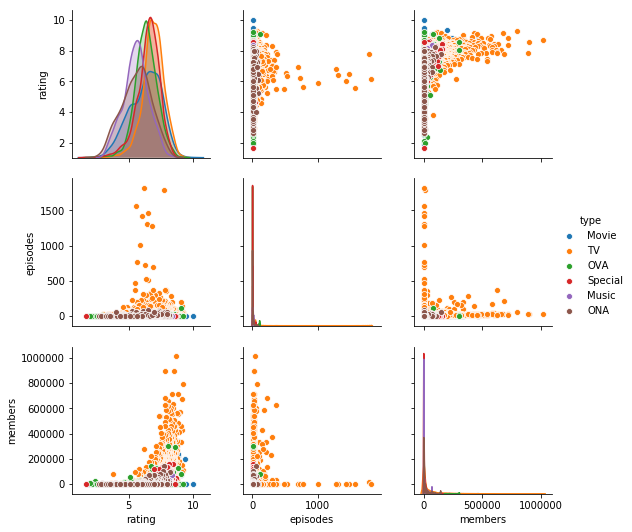

In [18]:
sns.pairplot(data=df_anime[['type','rating','episodes','members']].dropna(),hue='type')

- La distribución de los ratings es __Leptocúrtica__ ---->  es decir existe una gran concentración de los valores en torno a su media, con mayor presencia entre los ranking 5 y 8 (y algunos ouliers)
- En base a ello llenaremos los valores faltantes usando la MEDIANA de los rating 

(array([2.300e+02, 2.000e+00, 2.200e+01, 2.110e+02, 7.520e+02, 2.372e+03,
        4.784e+03, 3.294e+03, 6.030e+02, 2.400e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

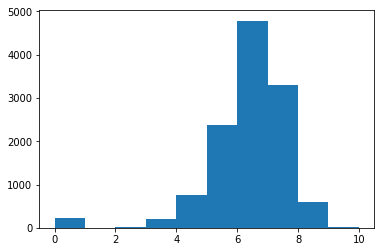

In [19]:
plt.hist(df_anime['rating'].fillna(0))

In [20]:
# rellenamos nan con la media 
df_anime['rating'] =df_anime['rating'].fillna(df_anime.rating.median())

(array([   6.,   49.,  275.,  733., 1824., 3884., 3822., 1467.,  225.,
           9.]),
 array([ 1.67 ,  2.503,  3.336,  4.169,  5.002,  5.835,  6.668,  7.501,
         8.334,  9.167, 10.   ]),
 <a list of 10 Patch objects>)

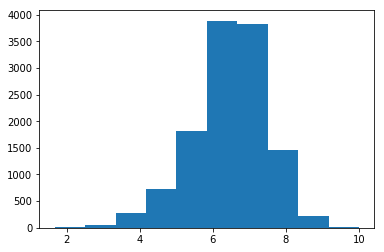

In [21]:
plt.hist(df_anime['rating'].fillna(0))

In [22]:
# es posible ver el cambio en la distribucion

In [23]:
# Veamos especificamente cuantas valoraciones existen

pd.DataFrame(df_ratings.groupby('rating').user_id.count()).reset_index()

rating  user_id
0     1.0    16649
1     2.0    23150
2     3.0    41453
3     4.0   104291
4     5.0   282806
5     6.0   637775
6     7.0  1375287
7     8.0  1646019
8     9.0  1254096
9    10.0   955715

In [24]:
df_ratings.count() #hay datos perdidos en rating 

user_id     7813737
anime_id    7813737
rating      6337241
dtype: int64

In [25]:
# selección de animes que tengan cantidad de rating superior a 80 para hacer mas rapida la consulta
# para ello explorar distribucion x tipo

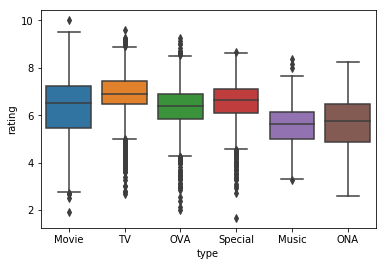

In [26]:
sns.boxplot(data = df_anime, y = 'rating', x='type')

__Priorizamos catogorizar por genero. Tambien cuantos usser han visto cada anime__

(array([1.0675e+04, 3.4500e+02, 1.0000e+02, 4.5000e+01, 1.7000e+01,
        7.0000e+00, 7.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 3.93490e+03, 7.86880e+03, 1.18027e+04, 1.57366e+04,
        1.96705e+04, 2.36044e+04, 2.75383e+04, 3.14722e+04, 3.54061e+04,
        3.93400e+04]),
 <a list of 10 Patch objects>)

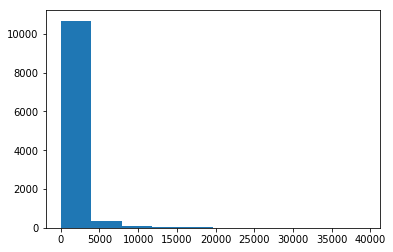

In [27]:
plt.hist(df_ratings.groupby(['anime_id'])['anime_id'].count())

Existe un sesgo, pues recomendara las series mas vistas sobre las menos vistas (Ver grafico)

La informacion del dataset establese que las serie  series sin rating no han sido evaluadas ya que no se encuentran aun en emision o no han sido lanzadas, por lo que trataremos que nuestro sistema tambien sea capaz de recomendarlas.

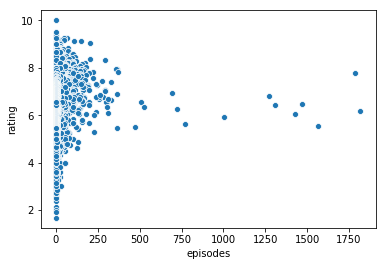

In [28]:
sns.scatterplot( x = df_anime['episodes'], y= df_anime['rating'])

Se prefiere anime con menor cantidad de episodios

## Representaciones Matriciales

* Unimos los datasets para extraer subsets de entrenamiento!

In [29]:
fulldf = pd.merge(df_anime, df_ratings, how = 'right', on ='anime_id', suffixes = ['_avg', '_user'])
fulldf.rename(columns = {'rating_user':'user_rating', 'rating_avg':'avg_rating'}, inplace = True)

In [30]:
fulldf.sample(10)

anime_id                                               name  \
5632306       180                                           Vandread   
7447070     13807                      Corpse Party: Missing Footage   
7028260      9581                                       MM! Specials   
3610654      3931                           Initial D Battle Stage 2   
3224572      6956                                          Working!!   
4009071     10020  Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...   
4104294     32828                                  Amaama to Inazuma   
387133      20583                                          Haikyuu!!   
5514742       195                                     Onegai☆Teacher   
4424683        64                                       Rozen Maiden   

                                                genre     type  episodes  \
5632306  Action, Ecchi, Mecha, Sci-Fi, Shounen, Space       TV      13.0   
7447070                                Horror, School      OVA       1.0   
7028260                         Comedy, Ecchi, School  Special       9.0   
3610654           Action, Cars, Drama, Seinen, Sports      OVA       1.0   
3224572                         Comedy, Slice of Life       TV      13.0   
4009071                 Comedy, Seinen, Slice of Life      ONA       4.0   
4104294                 Comedy, Seinen, Slice of Life       TV      12.0   
387133         Comedy, Drama, School, Shounen, Sports       TV      25.0   
5514742        Comedy, Drama, Romance, School, Sci-Fi       TV      12.0   
4424683          Action, Comedy, Drama, Magic, Seinen       TV      12.0   

         avg_rating   members  user_id  user_rating  
5632306        7.33   53360.0    21621          8.0  
7447070        6.38   57507.0    20467          6.0  
7028260        6.77   21462.0    20605          NaN  
3610654        7.74   11015.0    39836          5.0  
3224572        7.82  189367.0    45487          8.0  
4009071        7.66  101495.0    14619          NaN  
4104294        7.63   95339.0    14637          8.0  
387133         8.68  284498.0     4289         10.0  
5514742        7.35   99558.0    56301          NaN  
4424683        7.57  128688.0    59223          5.0

In [31]:
df_genres_list = df_anime['genre'].str.get_dummies(sep = ', ')

## Para el filtro de Contenido

In [32]:
df_genres_list.sample(10)

Action  Adventure  Cars  Comedy  Dark Fantasy  Dementia  Demons  Drama  \
1721        0          0     0       1             0         0       0      1   
2023        0          0     0       1             0         0       0      1   
9537        0          0     0       1             0         0       0      0   
4022        0          0     0       1             0         0       0      0   
3187        0          0     0       0             0         0       0      1   
1998        0          0     0       0             0         0       0      0   
10601       0          0     0       0             0         0       0      0   
2443        0          1     0       1             0         0       0      0   
2085        0          0     0       1             0         0       0      0   
5428        0          0     0       1             0         0       0      0   

       Ecchi  Fantasy  ...  Shounen Ai  Slice of Life  Space  Sports  \
1721       0        0  ...           0              0      0       0   
2023       0        0  ...           0              0      0       0   
9537       0        0  ...           0              0      0       1   
4022       0        1  ...           0              0      0       0   
3187       0        0  ...           0              0      0       0   
1998       0        0  ...           0              0      0       0   
10601      0        0  ...           0              0      0       0   
2443       0        1  ...           0              0      0       0   
2085       0        0  ...           0              0      0       0   
5428       1        0  ...           0              0      0       0   

       Super Power  Supernatural  Thriller  Vampire  Yaoi  Yuri  
1721             0             0         0        0     0     0  
2023             0             0         0        0     0     0  
9537             0             0         0        0     0     0  
4022             0             0         0        0     0     0  
3187             0             0         0        0     0     0  
1998             0             1         0        0     0     0  
10601            0             0         0        0     0     0  
2443             0             0         0        0     0     0  
2085             0             0         0        0     0     0  
5428             0             0         0        0     0     0  

[10 rows x 46 columns]

In [33]:
df_types_list = pd.get_dummies(df_anime[["type"]])
df_types_list.sample(10)

type_Movie  type_Music  type_ONA  type_OVA  type_Special  type_TV
3941            0           0         0         0             0        1
6489            0           0         0         1             0        0
2040            0           0         0         0             0        1
2085            0           0         0         0             0        1
10984           0           0         0         0             0        1
11927           0           0         0         1             0        0
11323           0           0         0         1             0        0
9463            0           0         0         0             0        1
11251           0           0         0         1             0        0
12218           0           0         0         1             0        0

In [34]:
#crear el dataset de entrenamiento final para contenido
df_feat = df_anime[['members','rating','episodes']]
df_features = pd.concat([df_feat,df_genres_list, df_types_list], axis = 1).fillna(0)

In [57]:
df_features.head()

members  rating  episodes  Action  Adventure  Cars  Comedy  Dark Fantasy  \
0   200630    9.37       1.0       0          0     0       0             0   
1   793665    9.26      64.0       1          1     0       0             0   
2   114262    9.25      51.0       1          0     0       1             0   
3   673572    9.17      24.0       0          0     0       0             0   
4   151266    9.16      51.0       1          0     0       1             0   

   Dementia  Demons  ...  Thriller  Vampire  Yaoi  Yuri  type_Movie  \
0         0       0  ...         0        0     0     0           1   
1         0       0  ...         0        0     0     0           0   
2         0       0  ...         0        0     0     0           0   
3         0       0  ...         1        0     0     0           0   
4         0       0  ...         0        0     0     0           0   

   type_Music  type_ONA  type_OVA  type_Special  type_TV  
0           0         0         0             0        0  
1           0         0         0             0        1  
2           0         0         0             0        1  
3           0         0         0             0        1  
4           0         0         0             0        1  

[5 rows x 55 columns]

In [35]:
#funciones de Apoyo

In [36]:
def get_nombre_from_index(index):
    return df_anime[df_anime.index == index]['name'].values[0]
def get_id_from_nombre(name):
    return df_anime[df_anime.name == name]['anime_id'].values[0]
def get_index_from_id(anime_id):
    return df_anime[df_anime.anime_id == anime_id].index.values[0]

In [37]:
#Obtendremos el promedio de las valoraciones que el usuario ha dado a las series para determinar si le gustan
# recomendaremos series similares a sus favoritas o mejor valoradas.
## Consideraremos el valor promedio de las series que el usuario haya evaluado
def get_user_top_list(user):
    df_user = df_ratings[df_ratings['user_id']==user]
    df_rated = df_user.dropna(how = 'any')
    avg =  df_rated.rating.mean() 
    df_toplist = df_rated[df_rated['rating']>= avg].sort_values('rating', ascending = False).head(10)
    return list(df_toplist['anime_id'])
def get_user_viewed_list(user):
    return list(df_ratings[df_ratings['user_id']==user]['anime_id'])

## Modelado por KNN (Contenido)

* Se usa k = K+1 siendo K el numero de recomendaciones que se desea obtener, ya que la primera siempre es el mismo dato
* Como tenemos variables dummy binarias vs variables con valor muy alto (episodios, miembros) se utilizara  la biblioteca MaxAbsScaler para convertir dichos valores en una distribucion 0-1. Equivale a normalizar con funcion Z

In [38]:
mas = MaxAbsScaler()
df_features2 = mas.fit_transform(df_features)

In [39]:
k = 10

In [40]:
neighbors_content = NearestNeighbors(n_neighbors = k, algorithm = 'ball_tree')

In [62]:
neighbors_content

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [41]:
neighbors_content.fit(df_features2)
# entrenamos 

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [42]:
distances, indices = neighbors_content.kneighbors(df_features2)

In [43]:
distances.shape

(12294, 10)

In [44]:
indices.shape

(12294, 10)

In [45]:
def get_recommendations(aid):
    anime =  get_index_from_id(aid)
    test = list(indices[anime,1:11])
    nb = []
    for i in test:
        a_name = get_nombre_from_index(i)
        nb.append(a_name)
    return nb

### Ver comparacion entre la recomendacion y la serie

* Extraer las series que el usuario ya haya visto

In [46]:
get_user_top_list(73509)

[199]

In [47]:
get_recommendations(23283)

['Re:Zero kara Hajimeru Isekai Seikatsu',
 'Mahou Shoujo Madoka★Magica',
 'Higurashi no Naku Koro ni Kai',
 'Gyakkyou Burai Kaiji: Ultimate Survivor',
 'Selector Infected WIXOSS',
 'Gyakkyou Burai Kaiji: Hakairoku-hen',
 'Touhai Densetsu Akagi: Yami ni Maiorita Tensai',
 'Selector Spread WIXOSS',
 'Steins;Gate']

* Recomendar series hasta que encontremos n series que el usuario no ha visto

In [48]:
def get_n_recommends(user, n):
    vistas = list(get_user_viewed_list(user))
    liked = list(get_user_top_list(user))
    lista = []
    for i in liked:
        ani = pd.Series(get_recommendations(i))
        recs = np.setdiff1d(ani, vistas) 
        lista.extend(recs)
        if(len(lista) > n):
            lista = lista[n:]
            break
    return lista

* probar para un usuario cualquiera de acuerdo a la lista anterior

In [49]:
get_n_recommends(3,5)

['Saint Luminous Jogakuin',
 'Shinreigari: Ghost Hound',
 'UN-GO',
 'Umineko no Naku Koro ni']

In [50]:
get_n_recommends(73509, 10)

['Bakemono no Ko',
 'Da Yu Hai Tang',
 'Jungle Taitei Leo: Hon-o-ji',
 'Mai Mai Shinko to Sennen no Mahou',
 'Marco: Haha wo Tazunete Sanzenri',
 'Momo e no Tegami',
 'Oseam',
 'Shisha no Sho',
 'Tobe! Kujira no Peek']

In [51]:
get_n_recommends(2, 10)

['Area no Kishi',
 'Diamond no Ace',
 'Diamond no Ace: Second Season',
 'Haikyuu!!',
 'Kuroko no Basket 2nd Season',
 'Kuroko no Basket 3rd Season',
 'Teekyuu',
 'Teekyuu 2',
 'Teekyuu 3']

In [52]:
get_n_recommends(5, 10)

['Gin no Saji',
 'Gin no Saji 2nd Season',
 'Isshuukan Friends.',
 'Kimi to Boku.',
 'Kimi to Boku. 2',
 'Seitokai Yakuindomo',
 'Seitokai Yakuindomo*',
 'Watashi ga Motenai no wa Dou Kangaetemo Omaera ga Warui!']

In [53]:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [59]:
# exporto modelo
import pickle
pickle.dump(neighbors_content, open('Knnanime.sav', 'wb'))

In [64]:
pickle.dump(distances, open('distances.sav', 'wb')) #tengo la duda si este va ??
pickle.dump(indices, open('indices.sav', 'wb')) # tengo la duda si este va ?? 

In [68]:
# load the model from disk
loaded_model = pickle.load(open('Knnanime.sav', 'rb'))
distances2 = pickle.load(open('distances.sav', 'rb'))
indices2 = pickle.load(open('indices.sav', 'rb'))

In [69]:
loaded_model #ver si vargo modelo

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [72]:
indices2.shape

(12294, 10)

In [73]:
distances2.shape

(12294, 10)